Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---


# Model Interpretation 2

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [X] Make a Shapley force plot to explain at least 1 individual prediction.
- [ ] Share at least 1 visualization on Slack.

(If you haven't completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!


## Links
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [5]:
!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 245kB 4.6MB/s 
  Created wheel for shap: filename=shap-0.30.2-cp36-cp36m-linux_x86_64.whl size=360634 sha256=6a117f23966635df101e8ce76a221759fa9f20a14a9637080fab39a9b7c4d665
  Stored in directory: /root/.cache/pip/wheels/97/46/c9/b9dc708249af7eaf0951b2be62e0f6191f4de385a48e1a4cb7
Successfully built shap


Genre            0
ESRB_Rating      0
Platform         0
Publisher        0
Developer        0
Total_Shipped    0
Global_Sales     0
Year             0
dtype: int64
Columns: ['Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Developer', 'Total_Shipped', 'Global_Sales', 'Year']
Baseline Accuracy: 0.7862559844087615
Validation Accuracy: 0.9978269521231095
Test Accuracy: 0.9995875828455225


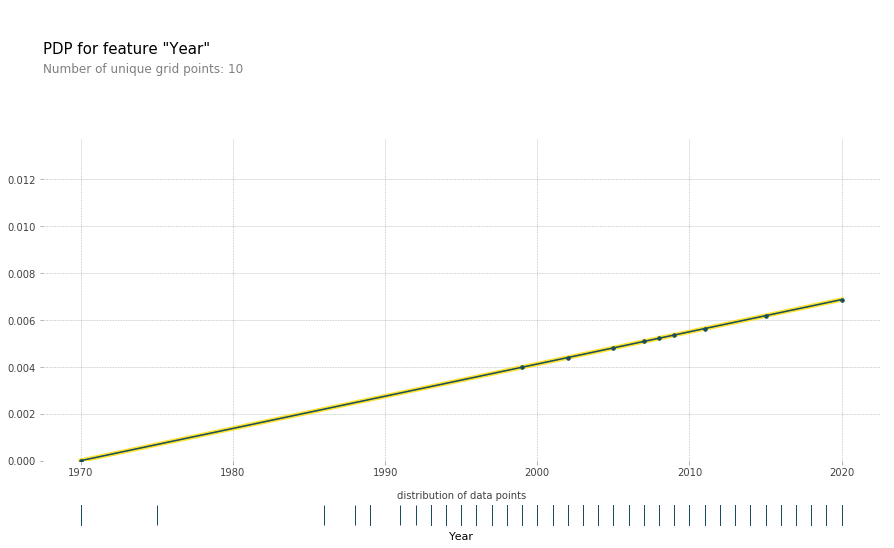

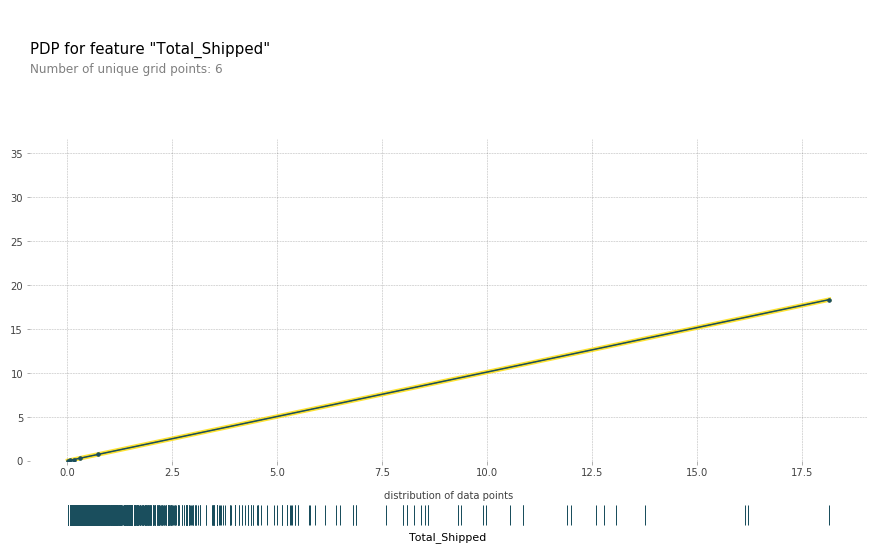

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
import category_encoders as ce

data = pd.read_csv("https://raw.githubusercontent.com/apathyhill/DS-Unit-2-Applied-Modeling/master/data/portfolio/vgsales-12-4-2019.csv")
data2 = data.copy()
#data2["score"] = data2[["VGChartz_Score", "Critic_Score", "User_Score"]].mean(axis=1)

features_excluded = ["Last_Update", "url", "status", "Vgchartzscore", "img_url", "basename", 
                     "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales", "Rank", "Name", 
                     "VGChartz_Score", "Critic_Score", "User_Score"]

data2 = data2.drop(features_excluded, axis=1)

data2["Year"] = data2["Year"].fillna(data2["Year"].median())
data2["Total_Shipped"] = data2["Total_Shipped"].fillna(method="ffill")
data2["Global_Sales"] = data2["Global_Sales"].fillna(method="ffill")
data2 = data2.dropna()

print(data2.isna().sum())
print("Columns:", list(data2.columns))
target = "Global_Sales"

train, test = train_test_split(data2, train_size=0.90)
train, val = train_test_split(train, train_size=0.75)

"""
This is a regression problem, as I am trying to output a continous number.

Simple accuracy could work as a eval matric right now, but I might change it to mean absolue/squared error to see if I can decipher things better.
"""

features_excluded = ["Last_Update", "url", "status", "Vgchartzscore", "img_url", "basename", 
                     "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales", "Rank", "Name", 
                     "VGChartz_Score", "Critic_Score", "User_Score", "ESRB_Rating"]
"""
These last columns are only for information about the game on the VGChartz website, such as cover images, and the url to the game. Not important here.
"basename" is a web-safe, simplified name of the game. (Wii Sports becomes wii-sports)
"NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales" are just  "Global_Sales" split into regions; probably not necessary.
"Rank" is not needed, as it is functionally just an index.
Each entry is a new game with its own title, so the "Name" category is *very* high cardinality, too much to use.


This leaves Genre, ESRB Rating (in seperate columns), Platform, Plublisher, Developer, and Year
"""


#data2[target].plot(kind="hist", bins=50, figsize=(20, 10));

mean = data2[target].mean()
print("Baseline Accuracy:", len(data2[data2[target] < mean])/ len(data2[target]) ) # Baseline is 178,000 sales for 82% accuracy


enc = ce.OrdinalEncoder()
enc.fit(train)
train = enc.transform(train)
test= enc.transform(test)
val= enc.transform(val)



X_train = train[train.columns.drop(target)]
y_train = train[target]

X_val = val[val.columns.drop(target)]
y_val = val[target]

X_test = test[val.columns.drop(target)]
y_test = test[target]


from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
import numpy as np

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy="median", missing_values=np.nan), 
    Ridge()
)


pipeline.fit(X_train, y_train)
print("Validation Accuracy:", pipeline.score(X_val, y_val))
print("Test Accuracy:", pipeline.score(X_test, y_test))

from pdpbox.pdp import pdp_isolate, pdp_plot
feature = "Year"
f = list(data2[feature].unique())

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(pdp_isolate_out=isolated, feature_name=feature, plot_lines=True, frac_to_plot=100, plot_pts_dist=True);

feature = "Total_Shipped"

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(pdp_isolate_out=isolated, feature_name=feature, plot_lines=True, frac_to_plot=100, plot_pts_dist=True);





In [4]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.4s finished


In [22]:
import shap
model = search.best_estimator_

def predict():
    df = X_test.head(1)
    print(df)
    pred = model.predict(df)[0]
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df)
    
    features = df.columns
    features_val = df.values[0]
    shaps = pd.Series(shap_values[0], zip(features, features_val))
    
    print("This is estimated to sell", round(pred*1000000), "copies")
    print("The real amount was ", round(y_test.iloc[0]*1000000), "copies")
    
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=df
    )

predict()

       Genre  ESRB_Rating  Platform  ...  Developer  Total_Shipped    Year
14384    8.0            3       5.0  ...       -1.0           0.07  2009.0

[1 rows x 7 columns]
This is estimated to sell 49291.0 copies
The real amount was  60000.0 copies
